# Enhancement of Mental illness Prediction using Machine Learning
*A project made for VTU Final Year*

**Team Members:**
   - Aman K (4SF20CS006)
   - Prapti R Naik (4SF20CS090)
   - Vishal V S (4SF20CS177)

## Import Necessaries Libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'C:\Users\visha\Downloads\DASS_data_21.02.19\DASS_data_21.02.19\data.csv',sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39775 entries, 0 to 39774
Columns: 172 entries, Q1A to major
dtypes: int64(170), object(2)
memory usage: 52.2+ MB


## Data Cleaning
In the dataset, VCL6, VCL9, VCL12 are not real words and are used for validity check.
1. Create a new column in the DataFrame called 'wrongansw' and initializes it to zero for all rows.
2. Update the 'wrongansw' column based on a condition:
    It uses the where method of the DataFrame to apply a condition where df[''] equals 0. 
    If the condition is true, then the 'wrongansw' column remains unchanged.
    If the condition is false, then the 'wrongansw' column is incremented by 1.
3. Use answers that have checked at least 2 of the words
4. Drop 'wrongansw' and 'VCL' columns
5. Drop 'major' columns

In [58]:
df['wrongansw'] = 0
df['wrongansw'] = df['wrongansw'].where(df['VCL6']== 0, df['wrongansw'] + 1)
df['wrongansw'] = df['wrongansw'].where(df['VCL9']== 0, df['wrongansw'] + 1)
df['wrongansw'] = df['wrongansw'].where(df['VCL12']== 0, df['wrongansw'] + 1)

df.wrongansw.value_counts()

wrongansw
0    34583
1     4044
2      822
3      326
Name: count, dtype: int64

In [59]:
df = df[df['wrongansw'].isin([2, 3])]
df = df.drop(columns='wrongansw')
df.head(3)
df.shape

(1148, 172)

In [60]:
# removing the validity check columns
vcls = []
for i in range(1, 17):
    vcls.append('VCL' + str(i))
    
df = df.drop(columns=vcls)
df.shape

(1148, 156)

In [61]:
categorical = df.select_dtypes('object').columns

print('Categorical Columns: ', df[categorical].columns)
print(df[categorical].nunique())

# remove 'major' column
df = df.drop(['major'], axis=1)

Categorical Columns:  Index(['country', 'major'], dtype='object')
country     68
major      365
dtype: int64


## Labelling the questions that are for specific mental disorder

In [62]:
DASS_keys = {
    'Depression': [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42],
    'Anxiety': [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41],
    'Stress': [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39]
    }

## Data Collection
The scores for anxiety, depression and stress were calculated by adding the values associated with the answers to each question of the particular class. Once the final scores had been calculated, they were labelled according to severity, i.e. Extremely Severe, Severe, Moderate, Mild and Normal.

In [63]:
# Extract questions for each disorder
depr = ['Q' + str(i) + 'A' for i in DASS_keys["Depression"]]
anx = ['Q' + str(i) + 'A' for i in DASS_keys["Anxiety"]]
stre = ['Q' + str(i) + 'A' for i in DASS_keys["Stress"]]

# Create dataframes for each disorder
df_depr = df.filter(depr)
df_anx = df.filter(anx)
df_stre = df.filter(stre)
disorders = [depr, anx, stre]

In [64]:
def scores(df): # adds new columns to store total scores for each        
    df["ScoresDepr"] = df[depr].sum(axis=1) 
    df["ScoresAnx"] = df[anx].sum(axis=1)
    df["ScoresStre"] = df[stre].sum(axis=1)
    return df

for i in disorders:
    df[i] -= 1 # to get the scores
        
df = scores(df)


In [65]:
# Define categories
def categorize(scores):
    if scores in range(0,10):
        return 'Normal'
    elif scores in range(10,14):
        return 'Minimal'
    elif scores in range(14,21):
        return 'Moderate'
    elif scores in range(21,28):
        return 'Severe'
    else:
        return 'Extremely Severe'

df['CategoryDepr']= df['ScoresDepr'].apply(categorize)


In [66]:
# CATEGORY: ANXIETY
CategoryAnx=[]

for i in df['ScoresAnx']:
    if i in range(0,8):
        CategoryAnx.append('Normal')
    elif i in range(8,10):
        CategoryAnx.append('Minimal')
    elif i in range(10,15):
        CategoryAnx.append('Moderate')
    elif i in range(15,20):
        CategoryAnx.append('Severe')
    else:
        CategoryAnx.append('Extremely Severe')
        
df['CategoryAnx']= CategoryAnx

In [67]:
# CATEGORY: STRESS
CategoryStre=[]

for i in df['ScoresStre']:
    if i in range(0,15):
        CategoryStre.append('Normal')
    elif i in range(15,19):
        CategoryStre.append('Minimal')
    elif i in range(19,26):
        CategoryStre.append('Moderate')
    elif i in range(26,34):
        CategoryStre.append('Severe')
    else:
        CategoryStre.append('Extremely Severe')
        
df['CategoryStre']= CategoryStre

In [68]:
# checking for duplicates
df.isnull().sum()
df.duplicated().sum()

0

In [69]:



df

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,race,voted,married,familysize,ScoresDepr,ScoresAnx,ScoresStre,CategoryDepr,CategoryAnx,CategoryStre
26,3,1,4820,3,39,1109,3,8,1833,3,...,60,2,1,3,38,41,41,Extremely Severe,Extremely Severe,Extremely Severe
31,1,25,3671,1,26,5743,1,13,3154,0,...,60,2,1,3,30,8,7,Extremely Severe,Minimal,Normal
57,1,27,3827,2,33,6293,1,22,12153,2,...,60,1,1,2,13,15,20,Minimal,Severe,Moderate
81,3,14,2205,0,25,3320,1,40,2803,0,...,70,2,1,6,20,10,31,Moderate,Moderate,Severe
87,2,4,8405,1,29,5819,3,32,1925,3,...,30,2,1,3,42,36,39,Extremely Severe,Extremely Severe,Extremely Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39621,2,10,3293,0,16,2830,2,12,3594,2,...,70,1,1,5,21,11,10,Severe,Moderate,Normal
39643,1,18,3731,0,10,1623,2,13,2876,0,...,10,1,1,3,23,7,11,Severe,Normal,Normal
39644,0,25,412,0,2,11824,0,29,349,0,...,30,1,0,7,0,1,3,Normal,Normal,Normal
39734,3,37,3099,1,21,4454,3,1,11688,0,...,60,1,3,3,42,26,41,Extremely Severe,Extremely Severe,Extremely Severe


## Data Classification Models for Depression

### Data Pre-processing

In [70]:


# Encode categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])



# Encode target variable
encoder = LabelEncoder()
Y = encoder.fit_transform(df['CategoryDepr'])

# Define X
X = df.drop(columns=['CategoryDepr'] + anx + stre)
X.head()

,Q1I,Q1E,Q2I,Q2E,Q3A,Q3I,Q3E,Q4I,Q4E,Q5A,...,orientation,race,voted,married,familysize,ScoresDepr,ScoresAnx,ScoresStre,CategoryAnx,CategoryStre
26,1,4820,39,1109,3,8,1833,34,1518,3,...,1,60,2,1,3,38,41,41,0,0
31,25,3671,26,5743,1,13,3154,21,5296,3,...,1,60,2,1,3,30,8,7,1,3
57,27,3827,33,6293,1,22,12153,3,27819,1,...,1,60,1,1,2,13,15,20,4,2
81,14,2205,25,3320,1,40,2803,24,3365,3,...,1,70,2,1,6,20,10,31,2,4
87,4,8405,29,5819,3,32,1925,11,2249,3,...,1,30,2,1,3,42,36,39,0,0


In [71]:
# Split data into features and target
X = df.drop(columns=['CategoryDepr'])
y = df['CategoryDepr']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [72]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=85)


### Classification Models

In [73]:
# KNN Model for Depression Classification

# Create a KNN classifier with k (number of neighbors)
knn = KNeighborsClassifier(n_neighbors=95)

# Fit the model to the training data
knn.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = knn.predict(X_test)

# Calculate the accuracy score of the model
accuracy_knn = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of KNN Model - Depression: {:.5f}'.format(accuracy_knn))
print('Confusion Matrix of KNN Model - Depression: \n', conf_matrix)
print('Confusion Matrix of KNN Model - Depression: \n', classif_report)

Accuracy of KNN Model - Depression: 0.72474
Confusion Matrix of KNN Model - Depression: 
 [[114   0   1   0   1]
 [  0   0   1  14   1]
 [  8   0  22   8   0]
 [  1   0   4  70   1]
 [ 22   0  10   7   2]]
Confusion Matrix of KNN Model - Depression: 
               precision    recall  f1-score   support

           0       0.79      0.98      0.87       116
           1       0.00      0.00      0.00        16
           2       0.58      0.58      0.58        38
           3       0.71      0.92      0.80        76
           4       0.40      0.05      0.09        41

    accuracy                           0.72       287
   macro avg       0.49      0.51      0.47       287
weighted avg       0.64      0.72      0.65       287



In [74]:
# SVC Model for Depression Classification
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, Y_train)

preds = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy_svc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of SVM Model - Depression: {:.5f}'.format(accuracy_svc))
print('Confusion Matrix of SVM Model - Depression: \n', conf_matrix)
print('Confusion Matrix of SVM Model - Depression: \n', classif_report)

Accuracy of SVM Model - Depression: 0.72474
Confusion Matrix of SVM Model - Depression: 
 [[114   0   1   0   1]
 [  0   0   1  14   1]
 [  8   0  22   8   0]
 [  1   0   4  70   1]
 [ 22   0  10   7   2]]
Confusion Matrix of SVM Model - Depression: 
               precision    recall  f1-score   support

           0       0.79      0.98      0.87       116
           1       0.00      0.00      0.00        16
           2       0.58      0.58      0.58        38
           3       0.71      0.92      0.80        76
           4       0.40      0.05      0.09        41

    accuracy                           0.72       287
   macro avg       0.49      0.51      0.47       287
weighted avg       0.64      0.72      0.65       287



## Multi-layer Perceptron (MLP)

Train accuracy: 0.9581881761550903
Test accuracy: 0.8083623647689819


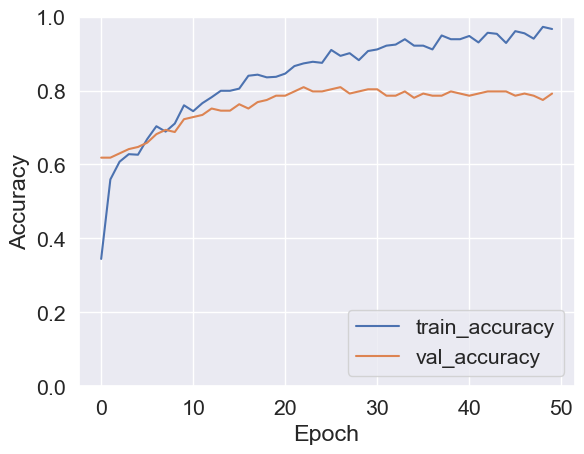

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix - Train Data
[[365   0   0   0   0]
 [  0  51   1   9   0]
 [  0   2 118   4   7]
 [  0   2   0 172   0]
 [  9   0   2   0 119]]


Confusion Matrix - Test Data
[[116   0   0   0   0]
 [  0   1   5  10   0]
 [  0   5  25   0   8]
 [  0   7   0  69   0]
 [ 13   0   7   0  21]]
Accuracy: 0.8083623693379791
Precision: 0.7919370189326883
Recall: 0.8083623693379791
F1 Score: 0.7963282080049175


In [75]:


import tensorflow as tf
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Dropout  # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax') # number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert predictions to integer classes
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Confusion matrices
confusion_matrix_train = confusion_matrix(Y_train, y_pred_train_classes)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test_classes)

print("Confusion Matrix - Train Data")
print(confusion_matrix_train)
print("\n")
print("Confusion Matrix - Test Data")
print(confusion_matrix_test)
# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred_test_classes)

# Calculate precision, recall, and F1-score
precision = precision_score(Y_test, y_pred_test_classes, average='weighted')
recall = recall_score(Y_test, y_pred_test_classes, average='weighted')
f1 = f1_score(Y_test, y_pred_test_classes, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)



In [76]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


# Define the parameter grid to search
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Create the LightGBM classifier
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt',
                              objective='multiclass',
                              metric='multi_logloss')

# Perform Grid Search CV
grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with best parameters
lgb_best = lgb.LGBMClassifier(**best_params)
lgb_best.fit(X_train, Y_train)

# Predictions
Y_pred = lgb_best.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 160
[LightGBM] [Info] Start training from score -0.858197
[LightGBM] [Info] Start training from score -2.647221
[LightGBM] [Info] Start training from score -1.882897
[LightGBM] [Info] Start training from score -1.599039
[LightGBM] [Info] Start training from score -1.890560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score

# Reshape the input data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train_cnn, Y_train, epochs=20, validation_data=(X_test_cnn, Y_test), verbose=1)

# Evaluate the model
Y_pred = model.predict(X_test_cnn)
Y_pred_classes = tf.argmax(Y_pred, axis=1)
accuracy = accuracy_score(Y_test, Y_pred_classes)
print("Accuracy:", accuracy)



Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5720 - loss: 1.1198 - val_accuracy: 0.7213 - val_loss: 0.7147
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7669 - loss: 0.6000 - val_accuracy: 0.7735 - val_loss: 0.5214
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8349 - loss: 0.4132 - val_accuracy: 0.8397 - val_loss: 0.4445
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9170 - loss: 0.2807 - val_accuracy: 0.8397 - val_loss: 0.4343
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9376 - loss: 0.2373 - val_accuracy: 0.8362 - val_loss: 0.4324
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9521 - loss: 0.1818 - val_accuracy: 0.8258 - val_loss: 0.4270
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9817 - loss: 0.1311 - val_accuracy: 0.8362 - val_loss: 0.4155
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9838 - loss: 0.1119 - val_accuracy: 0.8293 - val_loss

### Convolutional Neural Network (CNN) 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8362369337979094

Confusion Matrix:
 [[112   0   0   0   4]
 [  0   8   3   5   0]
 [  0   8  25   0   5]
 [  0   5   3  68   0]
 [  4   0  10   0  27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       116
           1       0.38      0.50      0.43        16
           2       0.61      0.66      0.63        38
           3       0.93      0.89      0.91        76
           4       0.75      0.66      0.70        41

    accuracy                           0.84       287
   macro avg       0.73      0.74      0.73       287
weighted avg       0.85      0.84      0.84       287



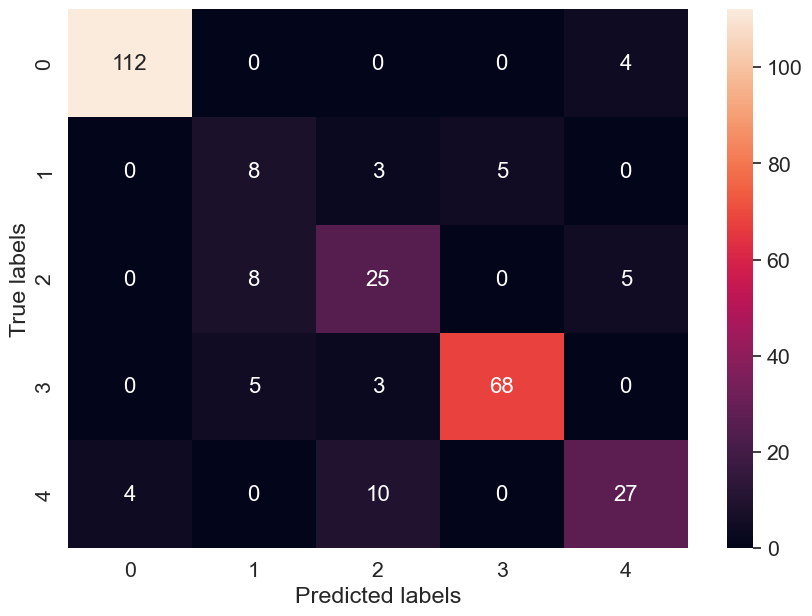

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict probabilities
Y_pred_prob = model.predict(X_test_cnn) 
# Predicted classes
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)

# Classification Report
cr = classification_report(Y_test, Y_pred)

# Print Accuracy, Confusion Matrix, and Classification Report
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)

# Plot Confusion Matrix
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [79]:
# Naive Bayes Model for Depression Classification

clfNB = GaussianNB()

# Fit the model to the training data
clfNB.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfNB.predict(X_test)

# Calculate the accuracy score of the model
accuracy_nb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of NB Model - Depression: {:.5f}'.format(accuracy_nb))
print('Confusion Matrix of NB Model - Depression: \n', conf_matrix)
print('Classification Report of NB Model - Depression: \n', classif_report)

Accuracy of NB Model - Depression: 0.66202
Confusion Matrix of NB Model - Depression: 
 [[93  0  4  0 19]
 [ 0 12  2  1  1]
 [ 2 16  6  0 14]
 [ 0 23  3 48  2]
 [ 7  0  3  0 31]]
Classification Report of NB Model - Depression: 
               precision    recall  f1-score   support

           0       0.91      0.80      0.85       116
           1       0.24      0.75      0.36        16
           2       0.33      0.16      0.21        38
           3       0.98      0.63      0.77        76
           4       0.46      0.76      0.57        41

    accuracy                           0.66       287
   macro avg       0.58      0.62      0.55       287
weighted avg       0.75      0.66      0.68       287



In [80]:
# Random Forest Classifier Model for Depression Classification

clfRFC = RandomForestClassifier(n_estimators=110, random_state=110)

# Fit the model to the training data
clfRFC.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfRFC.predict(X_test)

# Calculate the accuracy score of the model
accuracy_rfc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)


print('Accuracy of RFC Model - Depression: {:.5f}'.format(accuracy_rfc))
print('Confusion Matrix of RFC Model - Depression: \n', conf_matrix)
print('Classification report of RFC Model - Depression: \n', classif_report)

Accuracy of RFC Model - Depression: 0.96167
Confusion Matrix of RFC Model - Depression: 
 [[116   0   0   0   0]
 [  0   7   5   4   0]
 [  0   0  37   0   1]
 [  0   0   0  76   0]
 [  1   0   0   0  40]]
Classification report of RFC Model - Depression: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       116
           1       1.00      0.44      0.61        16
           2       0.88      0.97      0.93        38
           3       0.95      1.00      0.97        76
           4       0.98      0.98      0.98        41

    accuracy                           0.96       287
   macro avg       0.96      0.88      0.90       287
weighted avg       0.96      0.96      0.96       287



In [81]:
# XG Boost Classifier For Depression Classifier
xgb_model = XGBClassifier()
le = LabelEncoder()

xgb_model.fit(X_train, le.fit_transform(Y_train))

Y_pred = xgb_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

accuracy_xgb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of XGB Model - Depression: {:.5f}'.format(accuracy_xgb))
print('Confusion Matrix of XGB Model - Depression: \n', conf_matrix)
print('Classification report of XGB Model - Depression: \n', classif_report)  

Accuracy of XGB Model - Depression: 1.00000
Confusion Matrix of XGB Model - Depression: 
 [[116   0   0   0   0]
 [  0  16   0   0   0]
 [  0   0  38   0   0]
 [  0   0   0  76   0]
 [  0   0   0   0  41]]
Classification report of XGB Model - Depression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        76
           4       1.00      1.00      1.00        41

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [82]:
import numpy as np

# Combining Naive Bayes, XG Boost, and Random Forest

# Training the models on the whole data
final_xgb_model = XGBClassifier()
final_nb_model = GaussianNB()
final_rfc_model = RandomForestClassifier(n_estimators=110, random_state=110)

final_xgb_model.fit(X_train, le.fit_transform(Y_train))
final_nb_model.fit(X_train, Y_train)
final_rfc_model.fit(X_train, Y_train)

# Making predictions by taking the mode of predictions made by all the classifiers
xgb_preds = final_xgb_model.predict(X_test)
xgb_preds = le.inverse_transform(xgb_preds)

nb_preds = final_nb_model.predict(X_test)
rfc_preds = final_rfc_model.predict(X_test)

# Using numpy.unique to find the mode
final_preds = [np.unique([i, j, k])[np.argmax([np.sum(i == x) for x in np.unique([i, j, k])])] for i, j, k in zip(xgb_preds, nb_preds, rfc_preds)]

accuracy_combined = accuracy_score(Y_test, final_preds)
conf_matrix = confusion_matrix(Y_test, final_preds)
classif_report = classification_report(Y_test, final_preds)

print('Accuracy of Combined Model - Depression: {:.5f}'.format(accuracy_combined))
print('Confusion Matrix of Combined Model - Depression: \n', conf_matrix)
print('Classification report of Combined Model - Depression: \n', classif_report)



Accuracy of Combined Model - Depression: 1.00000
Confusion Matrix of Combined Model - Depression: 
 [[116   0   0   0   0]
 [  0  16   0   0   0]
 [  0   0  38   0   0]
 [  0   0   0  76   0]
 [  0   0   0   0  41]]
Classification report of Combined Model - Depression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        76
           4       1.00      1.00      1.00        41

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [83]:
accuracy_depression = [accuracy_knn, accuracy_svc, accuracy_nb, accuracy_rfc, accuracy_xgb, accuracy_combined]

depression_analysis = pd.DataFrame({
                        'Models' : ['KNN', 'SVC', 'Naive Bayes', 'Random Forest', 'XG Boost', 'Combined Model'],
                        'Accuracy_Depression': [x * 100 for x in accuracy_depression]
                    })

## Data Classification Models for Anxiety

### Data Pre-processing

In [84]:
Y = df['CategoryAnx']
X = df.drop(columns=['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','introelapse','testelapse', 'surveyelapse','engnat','CategoryAnx','CategoryDepr', 'CategoryStre','country', 'ScoresDepr' ,'ScoresStre','screensize','uniquenetworklocation','Q1A' ,'Q1I', 'Q1E', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E','Q4I','Q4E', 'Q5E', 'Q5A' ,'Q5I', 'Q6E', 'Q6A' ,'Q6I', 'Q7E' ,'Q7I', 'Q8E','Q8A' ,'Q8I', 'Q9E', 'Q9I', 'Q10E', 'Q10A', 'Q10I', 'Q11E', 'Q11A' ,'Q11I', 'Q12E', 'Q12A' ,'Q12I', 'Q13E', 'Q13A' ,'Q13I', 'Q14E', 'Q14A' ,'Q14I', 'Q15E', 'Q15I', 'Q16E', 'Q16A' ,'Q16I', 'Q17E', 'Q17A' ,'Q17I', 'Q18E', 'Q18A' ,'Q18I', 'Q19I', 'Q19E',  'Q20I', 'Q20E', 'Q21A', 'Q21I', 'Q21E', 'Q22A', 'Q22I','Q22E', 'Q23I','Q23E','Q24A','Q24I','Q24E', 'Q25I', 'Q25E', 'Q26A', 'Q26I', 'Q26E', 'Q27A', 'Q27I', 'Q27E', 'Q28I', 'Q28E', 'Q29A', 'Q29I', 'Q29E',  'Q30I', 'Q30E', 'Q31A', 'Q31I', 'Q31E', 'Q32A', 'Q32I', 'Q32E', 'Q33A', 'Q33I', 'Q33E', 'Q34A', 'Q34I', 'Q34E', 'Q35A', 'Q35I', 'Q35E', 'Q36I', 'Q36E', 'Q37A', 'Q37I', 'Q37E', 'Q38A', 'Q38I', 'Q38E', 'Q39A', 'Q39I', 'Q39E', 'Q40I', 'Q40E', 'Q41I', 'Q41E', 'Q42A', 'Q42I', 'Q42E'])
X.head()

,source,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,gender,age,hand,religion,orientation,race,voted,married,familysize,ScoresAnx
26,2,4,1,7,7,7,2,6,5,1,...,2,15,1,7,1,60,2,1,3,41
31,2,5,5,5,5,7,7,7,5,5,...,1,18,1,2,1,60,2,1,3,8
57,0,2,4,1,5,6,4,3,6,6,...,2,21,1,1,1,60,1,1,2,15
81,2,7,6,3,6,4,1,7,5,3,...,2,14,1,4,1,70,2,1,6,10
87,2,1,3,5,6,6,7,2,7,1,...,1,17,1,1,1,30,2,1,3,36


In [85]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [86]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=85)

### Classification Models

In [87]:
# KNN Classification
# Create a KNN classifier with k (number of neighbors)
knn = KNeighborsClassifier(n_neighbors=95)

# Fit the model to the training data
knn.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = knn.predict(X_test)

# Calculate the accuracy score of the model
accuracy_knn = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of KNN Model - Anxiety: {:.5f}'.format(accuracy_knn))
print('Confusion Matrix of KNN Model - Anxiety: \n', conf_matrix)
print('Confusion Matrix of KNN Model - Anxiety: \n', classif_report)

Accuracy of KNN Model - Anxiety: 0.63066
Confusion Matrix of KNN Model - Anxiety: 
 [[112   0   0   0   0]
 [  9   0   0  11   0]
 [ 24   0   0  10   0]
 [ 17   0   0  69   0]
 [ 35   0   0   0   0]]
Confusion Matrix of KNN Model - Anxiety: 
               precision    recall  f1-score   support

           0       0.57      1.00      0.72       112
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        34
           3       0.77      0.80      0.78        86
           4       0.00      0.00      0.00        35

    accuracy                           0.63       287
   macro avg       0.27      0.36      0.30       287
weighted avg       0.45      0.63      0.52       287



## Multi-layer Perceptron (MLP)

Train accuracy: 0.9523809552192688
Test accuracy: 0.8780487775802612


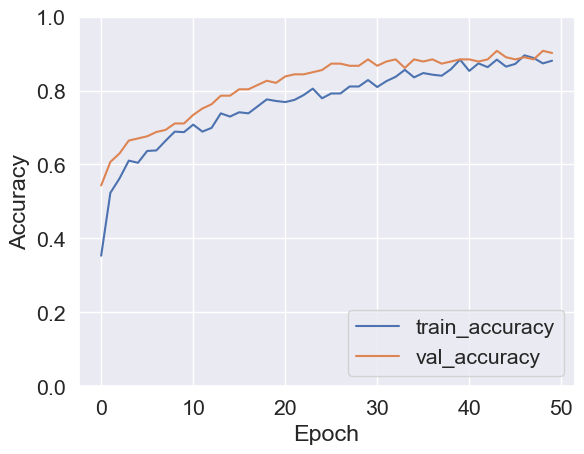

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix - Train Data
[[408   0   0   0   0]
 [  0   5   9  22   0]
 [  0   0 109   1   4]
 [  0   0   2 188   0]
 [  3   0   0   0 110]]


Confusion Matrix - Test Data
[[111   0   0   0   1]
 [  0   1   7  11   1]
 [  0   0  25   4   5]
 [  0   0   0  86   0]
 [  2   0   4   0  29]]
Accuracy: 0.8780487804878049
Precision: 0.8886793639124636
Recall: 0.8780487804878049
F1 Score: 0.8515341339058969


In [88]:


import tensorflow as tf
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Dropout  # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax') # number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert predictions to integer classes
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Confusion matrices
confusion_matrix_train = confusion_matrix(Y_train, y_pred_train_classes)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test_classes)

print("Confusion Matrix - Train Data")
print(confusion_matrix_train)
print("\n")
print("Confusion Matrix - Test Data")
print(confusion_matrix_test)
# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred_test_classes)

# Calculate precision, recall, and F1-score
precision = precision_score(Y_test, y_pred_test_classes, average='weighted')
recall = recall_score(Y_test, y_pred_test_classes, average='weighted')
f1 = f1_score(Y_test, y_pred_test_classes, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)



In [89]:
# SVC Model for Anxiety Classification
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, Y_train)

preds = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy_svc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of SVM Model - Anxiety: {:.5f}'.format(accuracy_svc))
print('Confusion Matrix of SVM Model - Anxiety: \n', conf_matrix)
print('Confusion Matrix of SVM Model - Anxiety: \n', classif_report)

Accuracy of SVM Model - Anxiety: 0.63066
Confusion Matrix of SVM Model - Anxiety: 
 [[112   0   0   0   0]
 [  9   0   0  11   0]
 [ 24   0   0  10   0]
 [ 17   0   0  69   0]
 [ 35   0   0   0   0]]
Confusion Matrix of SVM Model - Anxiety: 
               precision    recall  f1-score   support

           0       0.57      1.00      0.72       112
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        34
           3       0.77      0.80      0.78        86
           4       0.00      0.00      0.00        35

    accuracy                           0.63       287
   macro avg       0.27      0.36      0.30       287
weighted avg       0.45      0.63      0.52       287



In [90]:
# Naive Bayes Model for Anxiety Classification
clfNB = GaussianNB()

# Fit the model to the training data
clfNB.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfNB.predict(X_test)

# Calculate the accuracy score of the model
accuracy_nb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of NB Model - Anxiety: {:.5f}'.format(accuracy_nb))
print('Confusion Matrix of NB Model - Anxiety: \n', conf_matrix)
print('Classification Report of NB Model - Anxiety: \n', classif_report)

Accuracy of NB Model - Anxiety: 0.97213
Confusion Matrix of NB Model - Anxiety: 
 [[110   0   0   0   2]
 [  1  19   0   0   0]
 [  0   0  32   0   2]
 [  1   0   0  85   0]
 [  2   0   0   0  33]]
Classification Report of NB Model - Anxiety: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       112
           1       1.00      0.95      0.97        20
           2       1.00      0.94      0.97        34
           3       1.00      0.99      0.99        86
           4       0.89      0.94      0.92        35

    accuracy                           0.97       287
   macro avg       0.97      0.96      0.97       287
weighted avg       0.97      0.97      0.97       287



In [91]:
# Random Forest Classifier Model for Anxiety Classification
clfRFC = RandomForestClassifier(n_estimators=95, random_state=85)

# Fit the model to the training data
clfRFC.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfRFC.predict(X_test)

# Calculate the accuracy score of the model
accuracy_rfc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)


print('Accuracy of RFC Model - Anxiety: {:.5f}'.format(accuracy_rfc))
print('Confusion Matrix of RFC Model - Anxiety: \n', conf_matrix)
print('Classification report of KNN Model - Anxiety: \n', classif_report)

Accuracy of RFC Model - Anxiety: 0.94077
Confusion Matrix of RFC Model - Anxiety: 
 [[112   0   0   0   0]
 [  0   3  15   2   0]
 [  0   0  34   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  35]]
Classification report of KNN Model - Anxiety: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      0.15      0.26        20
           2       0.69      1.00      0.82        34
           3       0.98      1.00      0.99        86
           4       1.00      1.00      1.00        35

    accuracy                           0.94       287
   macro avg       0.93      0.83      0.81       287
weighted avg       0.96      0.94      0.92       287



In [92]:
# XG Boost Classifier For Anxiety Classifier
xgb_model = XGBClassifier()
le = LabelEncoder()

xgb_model.fit(X_train, le.fit_transform(Y_train))

Y_pred = xgb_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

accuracy_xgb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of XGB Model - Anxiety: {:.5f}'.format(accuracy_xgb))
print('Confusion Matrix of XGB Model - Anxiety: \n', conf_matrix)
print('Classification report of XGB Model - Anxiety: \n', classif_report)

Accuracy of XGB Model - Anxiety: 1.00000
Confusion Matrix of XGB Model - Anxiety: 
 [[112   0   0   0   0]
 [  0  20   0   0   0]
 [  0   0  34   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  35]]
Classification report of XGB Model - Anxiety: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        35

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [93]:
import numpy as np

# Combining Naive Bayes, XG Boost, and Random Forest

# Training the models on the whole data
final_xgb_model = XGBClassifier()
final_nb_model = GaussianNB()
final_rfc_model = RandomForestClassifier(n_estimators=110, random_state=110)

final_xgb_model.fit(X_train, le.fit_transform(Y_train))
final_nb_model.fit(X_train, Y_train)
final_rfc_model.fit(X_train, Y_train)

# Making predictions by taking the mode of predictions made by all the classifiers
xgb_preds = final_xgb_model.predict(X_test)
xgb_preds = le.inverse_transform(xgb_preds)

nb_preds = final_nb_model.predict(X_test)
rfc_preds = final_rfc_model.predict(X_test)

# Using numpy.unique to find the mode
final_preds = [np.unique([i, j, k])[np.argmax([np.sum(i == x) for x in np.unique([i, j, k])])] for i, j, k in zip(xgb_preds, nb_preds, rfc_preds)]

accuracy_combined = accuracy_score(Y_test, final_preds)
conf_matrix = confusion_matrix(Y_test, final_preds)
classif_report = classification_report(Y_test, final_preds)

print('Accuracy of Combined Model - Depression: {:.5f}'.format(accuracy_combined))
print('Confusion Matrix of Combined Model - Depression: \n', conf_matrix)
print('Classification report of Combined Model - Depression: \n', classif_report)


Accuracy of Combined Model - Depression: 1.00000
Confusion Matrix of Combined Model - Depression: 
 [[112   0   0   0   0]
 [  0  20   0   0   0]
 [  0   0  34   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  35]]
Classification report of Combined Model - Depression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        35

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [94]:
accuracy_anxiety = [accuracy_knn, accuracy_svc, accuracy_nb, accuracy_rfc, accuracy_xgb, accuracy_combined]

anxiety_analysis = pd.DataFrame({
                        'Models' : ['KNN', 'SVC', 'Naive Bayes', 'Random Forest', 'XG Boost', 'Combined Model'],
                        'Accuracy_Anxiety': [x * 100 for x in accuracy_anxiety]
                    })

## Data Classification Models for Stress

### Data Preprocessing

In [95]:
Y = df['CategoryStre']
X = df.drop(columns=['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','introelapse','testelapse', 'surveyelapse','engnat','CategoryStre','CategoryAnx', 'CategoryDepr', 'country', 'ScoresDepr' ,'ScoresAnx','screensize','uniquenetworklocation','Q1A' ,'Q1I', 'Q1E', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E','Q4I','Q4E', 'Q5E', 'Q5A' ,'Q5I', 'Q6E', 'Q6A' ,'Q6I', 'Q7E' ,'Q7I', 'Q8E','Q8A' ,'Q8I', 'Q9E', 'Q9I', 'Q10E', 'Q10A', 'Q10I', 'Q11E', 'Q11A' ,'Q11I', 'Q12E', 'Q12A' ,'Q12I', 'Q13E', 'Q13A' ,'Q13I', 'Q14E', 'Q14A' ,'Q14I', 'Q15E', 'Q15I', 'Q16E', 'Q16A' ,'Q16I', 'Q17E', 'Q17A' ,'Q17I', 'Q18E', 'Q18A' ,'Q18I', 'Q19I', 'Q19E',  'Q20I', 'Q20E', 'Q21A', 'Q21I', 'Q21E', 'Q22A', 'Q22I','Q22E', 'Q23I','Q23E','Q24A','Q24I','Q24E', 'Q25I', 'Q25E', 'Q26A', 'Q26I', 'Q26E', 'Q27A', 'Q27I', 'Q27E', 'Q28I', 'Q28E', 'Q29A', 'Q29I', 'Q29E',  'Q30I', 'Q30E', 'Q31A', 'Q31I', 'Q31E', 'Q32A', 'Q32I', 'Q32E', 'Q33A', 'Q33I', 'Q33E', 'Q34A', 'Q34I', 'Q34E', 'Q35A', 'Q35I', 'Q35E', 'Q36I', 'Q36E', 'Q37A', 'Q37I', 'Q37E', 'Q38A', 'Q38I', 'Q38E', 'Q39A', 'Q39I', 'Q39E', 'Q40I', 'Q40E', 'Q41I', 'Q41E', 'Q42A', 'Q42I', 'Q42E'])
X.head()

,source,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,gender,age,hand,religion,orientation,race,voted,married,familysize,ScoresStre
26,2,4,1,7,7,7,2,6,5,1,...,2,15,1,7,1,60,2,1,3,41
31,2,5,5,5,5,7,7,7,5,5,...,1,18,1,2,1,60,2,1,3,7
57,0,2,4,1,5,6,4,3,6,6,...,2,21,1,1,1,60,1,1,2,20
81,2,7,6,3,6,4,1,7,5,3,...,2,14,1,4,1,70,2,1,6,31
87,2,1,3,5,6,6,7,2,7,1,...,1,17,1,1,1,30,2,1,3,39


In [96]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [97]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=85)

### Classification Models

In [98]:
# KNN Model for Stress Classification

# Create a KNN classifier with k (number of neighbors)
knn = KNeighborsClassifier(n_neighbors=95)

# Fit the model to the training data
knn.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = knn.predict(X_test)

# Calculate the accuracy score of the model
accuracy_knn = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of KNN Model - Stress: {:.5f}'.format(accuracy_knn))
print('Confusion Matrix of KNN Model - Stress: \n', conf_matrix)
print('Confusion Matrix of KNN Model - Stress: \n', classif_report)

Accuracy of KNN Model - Stress: 0.49477
Confusion Matrix of KNN Model - Stress: 
 [[14  0  0  1 45]
 [ 0  0 10 13 12]
 [ 1  0 11 10 26]
 [ 0  0 11 72  3]
 [ 0  0  6  7 45]]
Confusion Matrix of KNN Model - Stress: 
               precision    recall  f1-score   support

           0       0.93      0.23      0.37        60
           1       0.00      0.00      0.00        35
           2       0.29      0.23      0.26        48
           3       0.70      0.84      0.76        86
           4       0.34      0.78      0.48        58

    accuracy                           0.49       287
   macro avg       0.45      0.42      0.37       287
weighted avg       0.52      0.49      0.45       287



## Multi-layer Perceptron (MLP)

Train accuracy: 0.9512194991111755
Test accuracy: 0.8501741886138916


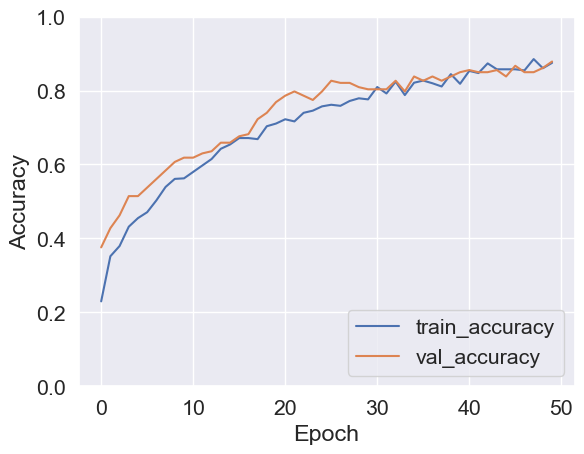

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix - Train Data
[[200   0   0   0   1]
 [  0  39   4  24   0]
 [  0   2 166   0   0]
 [  0   0   0 226   0]
 [ 11   0   0   0 188]]


Confusion Matrix - Test Data
[[59  0  0  0  1]
 [ 0  9  8 18  0]
 [ 0  1 45  1  1]
 [ 0  1  0 85  0]
 [10  0  2  0 46]]
Accuracy: 0.8501742160278746
Precision: 0.8539555177943302
Recall: 0.8501742160278746
F1 Score: 0.8285996924722063


In [99]:


import tensorflow as tf
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Dropout  # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax') # number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert predictions to integer classes
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Confusion matrices
confusion_matrix_train = confusion_matrix(Y_train, y_pred_train_classes)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test_classes)

print("Confusion Matrix - Train Data")
print(confusion_matrix_train)
print("\n")
print("Confusion Matrix - Test Data")
print(confusion_matrix_test)
# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred_test_classes)

# Calculate precision, recall, and F1-score
precision = precision_score(Y_test, y_pred_test_classes, average='weighted')
recall = recall_score(Y_test, y_pred_test_classes, average='weighted')
f1 = f1_score(Y_test, y_pred_test_classes, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)



In [100]:
# SVC Model for Stress Classification
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, Y_train)

preds = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy_svc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of SVM Model - Anxiety: {:.5f}'.format(accuracy_svc))
print('Confusion Matrix of SVM Model - Anxiety: \n', conf_matrix)
print('Confusion Matrix of SVM Model - Anxiety: \n', classif_report)

Accuracy of SVM Model - Anxiety: 0.49477
Confusion Matrix of SVM Model - Anxiety: 
 [[14  0  0  1 45]
 [ 0  0 10 13 12]
 [ 1  0 11 10 26]
 [ 0  0 11 72  3]
 [ 0  0  6  7 45]]
Confusion Matrix of SVM Model - Anxiety: 
               precision    recall  f1-score   support

           0       0.93      0.23      0.37        60
           1       0.00      0.00      0.00        35
           2       0.29      0.23      0.26        48
           3       0.70      0.84      0.76        86
           4       0.34      0.78      0.48        58

    accuracy                           0.49       287
   macro avg       0.45      0.42      0.37       287
weighted avg       0.52      0.49      0.45       287



In [101]:
# Naive Bayes Model for Stress Classification

clfNB = GaussianNB()

# Fit the model to the training data
clfNB.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfNB.predict(X_test)

# Calculate the accuracy score of the model
accuracy_nb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of NB Model - Stress: {:.5f}'.format(accuracy_nb))
print('Confusion Matrix of NB Model - Stress: \n', conf_matrix)
print('Classification Report of KNN Model - Stress: \n', classif_report)

Accuracy of NB Model - Stress: 0.93728
Confusion Matrix of NB Model - Stress: 
 [[59  0  0  0  1]
 [ 0 32  0  3  0]
 [ 1  1 43  1  2]
 [ 0  1  0 85  0]
 [ 3  0  5  0 50]]
Classification Report of KNN Model - Stress: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        60
           1       0.94      0.91      0.93        35
           2       0.90      0.90      0.90        48
           3       0.96      0.99      0.97        86
           4       0.94      0.86      0.90        58

    accuracy                           0.94       287
   macro avg       0.93      0.93      0.93       287
weighted avg       0.94      0.94      0.94       287



In [102]:
# Random Forest Classifier Model for Stress Classification

clfRFC = RandomForestClassifier(n_estimators=95, random_state=85)

# Fit the model to the training data
clfRFC.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfRFC.predict(X_test)

# Calculate the accuracy score of the model
accuracy_rfc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)


print('Accuracy of RFC Model - Stress: {:.5f}'.format(accuracy_rfc))
print('Confusion Matrix of RFC Model - Stress: \n', conf_matrix)
print('Classification report of KNN Model - Stress: \n', classif_report)

Accuracy of RFC Model - Stress: 0.96516
Confusion Matrix of RFC Model - Stress: 
 [[60  0  0  0  0]
 [ 0 25 10  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 86  0]
 [ 0  0  0  0 58]]
Classification report of KNN Model - Stress: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.71      0.83        35
           2       0.83      1.00      0.91        48
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        58

    accuracy                           0.97       287
   macro avg       0.97      0.94      0.95       287
weighted avg       0.97      0.97      0.96       287



In [103]:
# XG Boost Classifier For Stress Classifier
xgb_model = XGBClassifier()
le = LabelEncoder()

xgb_model.fit(X_train, le.fit_transform(Y_train))

Y_pred = xgb_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

accuracy_xgb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of XGB Model - Stress: {:.5f}'.format(accuracy_xgb))
print('Confusion Matrix of XGB Model - Stress: \n', conf_matrix)
print('Classification report of XGB Model - Stress: \n', classif_report)

Accuracy of XGB Model - Stress: 1.00000
Confusion Matrix of XGB Model - Stress: 
 [[60  0  0  0  0]
 [ 0 35  0  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 86  0]
 [ 0  0  0  0 58]]
Classification report of XGB Model - Stress: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        58

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287



In [104]:
from collections import Counter

# Combine predictions using majority voting
final_preds = [Counter([i, j, k]).most_common(1)[0][0] for i, j, k in zip(xgb_preds, nb_preds, rfc_preds)]

accuracy_combined = accuracy_score(Y_test, final_preds)
conf_matrix = confusion_matrix(Y_test, final_preds)
classif_report = classification_report(Y_test, final_preds)

print('Accuracy of Combined Model - Stress: {:.5f}'.format(accuracy_combined))
print('Confusion Matrix of Combined Model - Stress: \n', conf_matrix)
print('Classification report of Combined Model - Stress: \n', classif_report)


Accuracy of Combined Model - Stress: 0.50523
Confusion Matrix of Combined Model - Stress: 
 [[57  1  1  0  1]
 [ 6  3  9  8  9]
 [11  4 10 10 13]
 [ 1 10  8 65  2]
 [37  2  6  3 10]]
Classification report of Combined Model - Stress: 
               precision    recall  f1-score   support

           0       0.51      0.95      0.66        60
           1       0.15      0.09      0.11        35
           2       0.29      0.21      0.24        48
           3       0.76      0.76      0.76        86
           4       0.29      0.17      0.22        58

    accuracy                           0.51       287
   macro avg       0.40      0.43      0.40       287
weighted avg       0.46      0.51      0.46       287



In [105]:
accuracy_stress = [accuracy_knn, accuracy_svc, accuracy_nb, accuracy_rfc, accuracy_xgb, accuracy_combined]

stress_analysis = pd.DataFrame({
                        'Models' : ['KNN', 'SVC', 'Naive Bayes', 'Random Forest', 'XG Boost', 'Combined Model'],
                        'Accuracy_Stress': [x * 100 for x in accuracy_stress]
                    })

## Analysis of the Models Used

In [106]:
analysis = pd.concat([stress_analysis.set_index('Models'), 
                      anxiety_analysis.set_index('Models'), 
                      depression_analysis.set_index('Models')],
                     axis=1)

In [107]:
analysis.head()

,Accuracy_Stress,Accuracy_Anxiety,Accuracy_Depression
Models,,,
KNN,49.477352,63.066202,72.473868
SVC,49.477352,63.066202,72.473868
Naive Bayes,93.728223,97.212544,66.202091
Random Forest,96.515679,94.076655,96.167247
XG Boost,100.000000,100.000000,100.000000


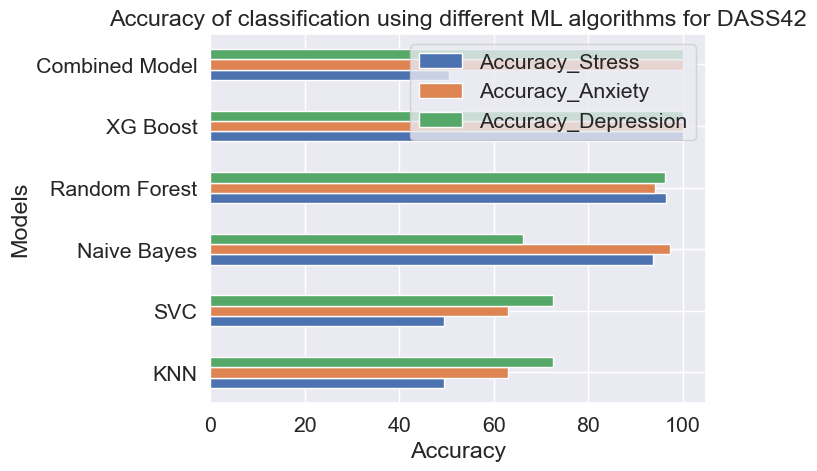

In [108]:
ax = analysis.plot(kind='barh')
plt.title("Accuracy of classification using different ML algorithms for DASS42")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.show()